## Here we will the same things that we do in previosly , but inside a class 

In [70]:
import numpy as np
import datetime 


import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')


dateime.datetime.now()

In [108]:
class StepByStep(object):
    def __init__(self , model, loss_fn , optimizer):
        self.model = model 
        self.loss_fn = loss_fn 
        self.optimizer = optimizer 
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)

        
        self.train_loader = None 
        self.val_loader = None 
        self.writer = None 

        #variables (these arrtibutes are going to computed internally )
        self.losses = [] 
        self.val_losses = [] 
        self.total_epochs = 0 

        # functional attributes 
        self.train_step_fn = self._make_train_step_fn()
        #create the val step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()
    
    #giving user option to seletect the device 
    def to(self , device): 
        try :
            self.device = device 
            self.model.to(device)
        except RuntimeError:
            self.device = ('cuda' if torch.cuda.is_avaiable() else 'cpu')
            print(f"Couldn't send it to {device} \n sending it to {self.device} instead.")
            self.model.to(self.device)


    def set_loaders(self , train_loader , val_loader = None ):
        self.train_loader = train_loader 
        self.val_loader = val_loader 

    def set_tesorboard(self , name , folder = 'rus'):
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')

    def _make_train_step_fn(self):

        def perform_train_step_fn(x , y):
            #set model to train 
            model.train()
            yhat = self.model(x)

            loss = self.loss_fn(yhat , y)
            loss.backward()  #compute gradients 
            self.optimizer.step()
            self.optimizer.zero_grad()
            return loss.item()
        return perform_train_step_fn
    
    def _make_val_step_fn(self):
        def perform_val_step_fn(x , y):
            #model eval 
            model.eval()
            yhat = self.model(x)
            loss = self.loss_fn(yhat , y)

            return loss.item()
        return perform_val_step_fn
    
    def _mini_batch(self , validation  = False ):
        if validation : 
            data_loader = self.val_loader
            step_fn = self.val_step_fn 

        else :
            data_loader = self.train_loader 
            step_fn = self.train_step_fn 

        if data_loader is None : 
            return None 
        mini_batch_losses = [] 
        for x_batch , y_batch in data_loader :
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch , y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss 
    ##################################traning loop ################################################
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False    
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self , n_epcohs:int , seed= 42)-> None :
        #this function does't return anything  , it uppdates several class attributes self.losses  , self.val_losses and self.total_epoch
        self.set_seed(seed)
        
        for epcoh in range(n_epcohs):
            #keep the track of the number of epoch
            self.total_epochs += 1 
            
            #inner loop 
            #perfrom tranning using mini batches 
            loss = self._mini_batch(validation = False)
            self.losses.append(loss)

            #validation 
            
            with torch.no_grad():
                #perform eval 
                val_loss =self._mini_batch(validation= True)
                self.val_losses.append(val_loss)

            #if summaywriter  has been set then 
            if self.writer :
                scalars = {'training':loss} 
                
                if val_loss is not None :
                    scalars.update({'Validation' : val_loss} )

                #record both losses for each epcoh under tag loss 
                self.writer.add_scalars(main_tag = 'loss' , 
                                        tag_scalar_dict = scalars , 
                                        global_step  = epcoh)
                
        if self.writer:
            #flushes the writer 
            self.writer.flush()

    ######################saving and loading models########################################
    def save_checkpoint(self, filename):
        #builds dictionary with all elements for resumin training 
        checkpoint = {
            'epoch':self.total_epochs , 
            'model_state_dict':self.model.state_dict(),
            'optimizer_state_dict':self.optimizer.state_dict() , 
            'loss':self.losses , 
            'val_loss' : self.val_losses
        }
        torch.save(checkpoint , filename)

    def load_checkpoint(self , filename):
        #load dictionaly
        checkpoint = torch.load(filename)

        #restore state for model and optimizer 
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']
        self.model.train() # always trai model while resuming tranning 
    
    ############################## prediction ###################################################
    def prediction(self , x ):
        #always set model to evaluation while precition 
        self.model.eval()

        #input is on numpy array convert into tensor 
        x_tensor = torch.as_tensor(x).float()
        #send input to device and use model for prediction 

        y_hat_tensor = self.model(x_tensor.to(self.device))

        #setback to train mode
        self.model.train()

        #detach  , and bring  it to cpu and back to numpy 
        return y_hat_tensor.detach().cpu().numpy()
    


################################## plottig ##############################################

    def plot_losses(self):
        fig = plt.figure(figsize=(10 , 4))
        plt.plot(self.losses , label = 'Training Loss ' , c = 'b')
        if self.val_loader :
            plt.plot(self.val_losses , label = 'validation Loss ' , c = 'r')

        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('loss')
        plt.legend()
        plt.tight_layout()
        return fig
############################# add graph ###########################
def add_graph(self):
    if self.train_loader and self.write:
        #fetch single mini batch 
        x_dummy , y_dummy = next(iter(self.train_loader))
        self.writer.add_graph(self.model , x_dummy.to(self.device))

    

In [109]:
#generate data

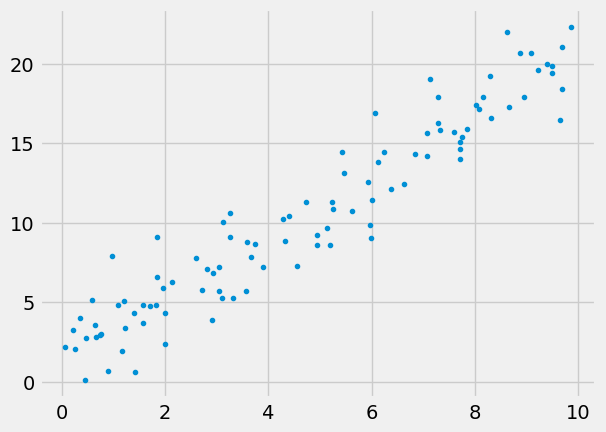

<Figure size 640x480 with 0 Axes>

In [110]:
%run data_generation/simple_linear_regression.py


### editing model configuratio because  , some of its code got inegreated into our class soo reduce code and keep only the elements we need to pass as argument to our stepbystep class 
i.e model loss function , optimizer 

In [111]:
%%writefile model_configuration/v4.py
import torch 
import torch.nn as nn
import torch.optim as optim 
lr = 0.01
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(1,1))
optimizer = optim.SGD(model.parameters() , lr = lr )
loss_fn  =  nn.MSELoss(reduction = 'mean')


Overwriting model_configuration/v4.py


In [112]:
%run -i model_configuration/v4.py

In [113]:
model.state_dict() #inspecting randomly initilized parameters 

OrderedDict([('0.weight', tensor([[0.7645]])), ('0.bias', tensor([0.8300]))])

## Model Tranning 

In [114]:
sbs = StepByStep(model ,loss_fn , optimizer)
sbs.set_loaders(train_loader , val_loader)
sbs.set_tesorboard('classy')

In [115]:
sbs.model

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)

In [116]:
model

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)

In [117]:
#train 
sbs.train(n_epcohs = 200)

In [118]:
model.state_dict()

OrderedDict([('0.weight', tensor([[1.9657]], device='cuda:0')),
             ('0.bias', tensor([1.7217], device='cuda:0'))])

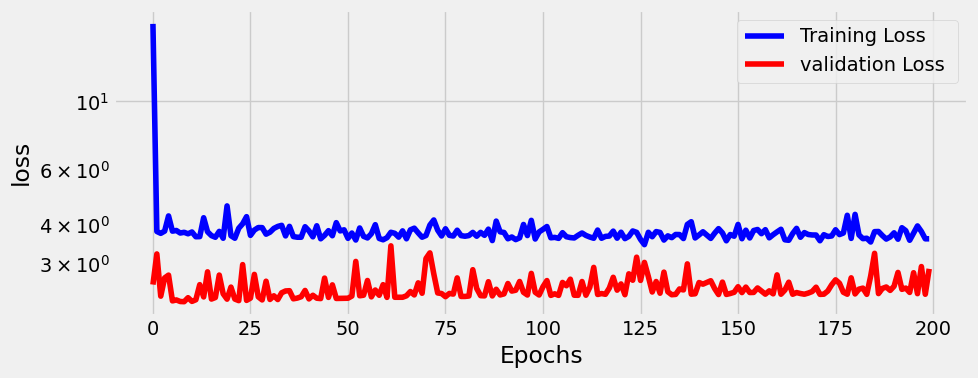

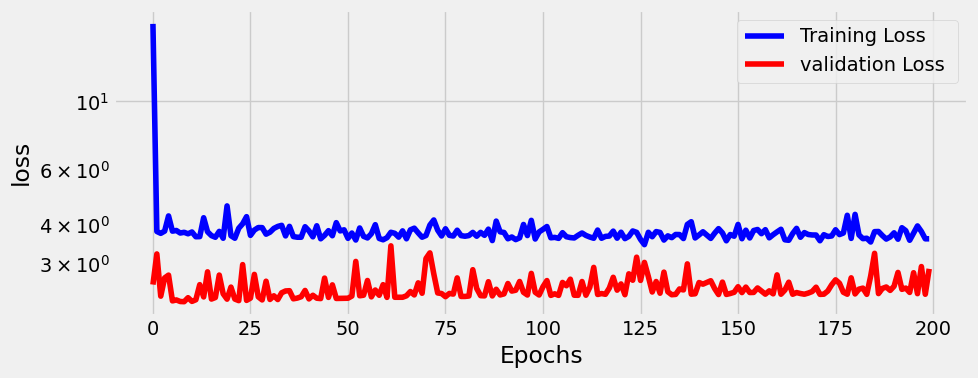

In [119]:
sbs.plot_losses()

## prediction 

In [120]:
new_data = np.array([.5, .3, .7]).reshape(-1, 1)
new_data

array([[0.5],
       [0.3],
       [0.7]])

In [121]:
predictions = sbs.prediction(new_data)
predictions

array([[2.7045157],
       [2.31137  ],
       [3.0976615]], dtype=float32)

## checkpoint 

In [122]:
sbs.save_checkpoint('model.checkpoint.pth')

## resume tranning 

In [123]:
#untrain data 
%run -i model_configuration/v4.py

<Figure size 640x480 with 0 Axes>

In [124]:
model.state_dict() #check if we untrain data or not 

OrderedDict([('0.weight', tensor([[0.7645]])), ('0.bias', tensor([0.8300]))])

In [125]:
new_sbs = StepByStep(model ,loss_fn , optimizer)


In [126]:
#load trained checkpoint 
new_sbs.load_checkpoint('model_checkpoint.pth')
model.state_dict()

OrderedDict([('0.weight', tensor([[2.0392]], device='cuda:0')),
             ('0.bias', tensor([9.7361], device='cuda:0'))])

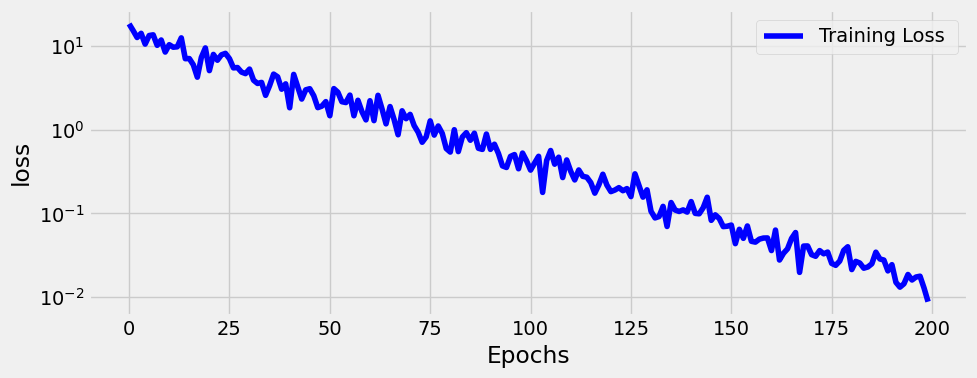

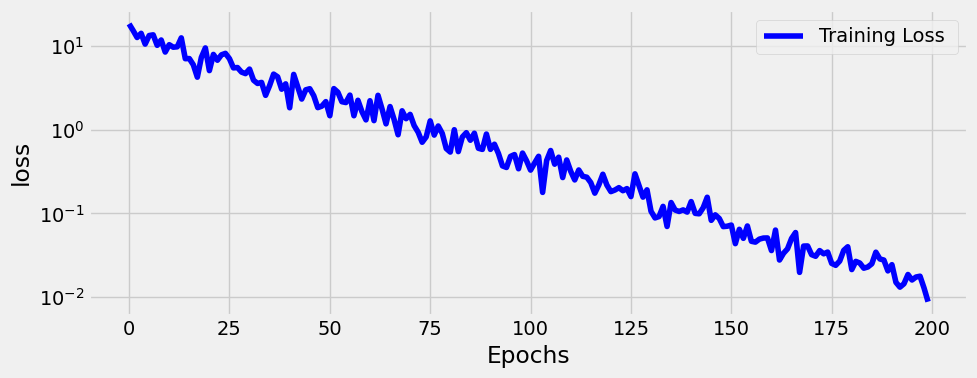

In [127]:
new_sbs.plot_losses()

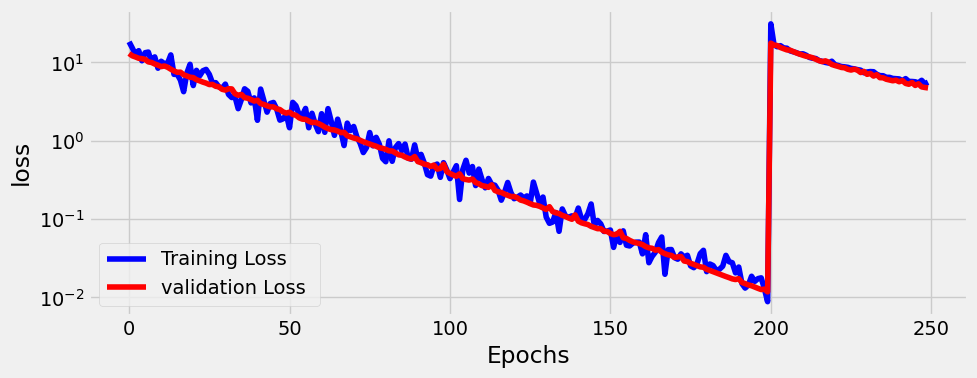

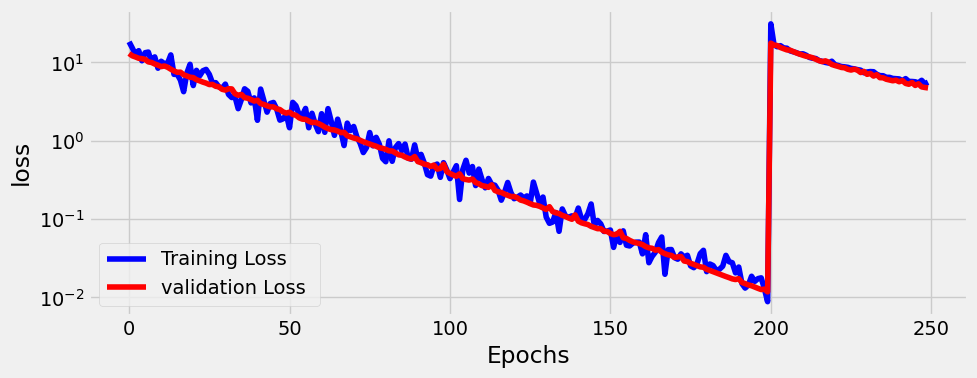

In [128]:
#trai futher with addition 50 epoch 
new_sbs.set_loaders(train_loader , val_loader)
new_sbs.train(n_epcohs= 50)
new_sbs.plot_losses()

In [129]:
#see how validation losses is increaseing after 200 epcohs 

In [131]:
sbs.model.state_dict()

OrderedDict([('0.weight', tensor([[1.9657]], device='cuda:0')),
             ('0.bias', tensor([1.7217], device='cuda:0'))])

In [132]:
new_sbs.model.state_dict()

OrderedDict([('0.weight', tensor([[1.4566]], device='cuda:0')),
             ('0.bias', tensor([4.3199], device='cuda:0'))])

In [2]:
a = [1 ,2,3,4]
b = [] 
b.append(a[:])

In [3]:
b

[[1, 2, 3, 4]]